# PhageHostLearn - v3.4.klebsiella - inference

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. 

This notebook offers complete functionality to make predictions for new bacteria, phages or both, using a trained PhageHostLearn prediction model for Klebsiella phage-host interactions.

**Overview of this notebook**
1. Initial set-up
2. Processing phage genomes and bacterial genomes into RBPs and K-locus proteins, respectively
3. Computing feature representations based on ESM-2.
4. Predicting new interactions and ranking

**Architecture of the PhageHostLearn framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both based on the ESM-2 language model.
- An XGBoost model on top of language embeddings to make predictions

## 1. Initial set-up

PhageHostLearn takes as inputs phage genomes and bacterial genomes that are later transformed into phage RBPs and bacterial K-locus proteins. To do this data processing, you'll need to do the following:
1. Set up a TEST folder for all the test data that will be stored and generated by PhageHostLearn. Write the path to this folder in the code block below for 'test_path'. The 'training_path' is the path to the training data as it is used in the `phagehostlearn_training.ipynb` notebook.
2. In the TEST folder, create one or two subfolders for the new phage genomes and/or bacterial genomes to test (one for phage genomes and one for bacterial genomes if you have both). Collect both phage genomes and bacterial genomes as individual FASTA files and store them in the two separate folders. You can also make predictions for either new bacteria or new phages against the training set, in that case you only need to create one subfolder.
3. Install [PHANOTATE](https://github.com/deprekate/PHANOTATE) and [Kaptive](https://github.com/katholt/Kaptive), both of which you'll need to process the phage and bacterial genomes. Locate PHANOTATE and write the path under the 2.1 code block below. **(Can be simplified by copying PHANOTATE into code folder.)** From the Kaptive repository, copy the .gbk databases into the training data folder.
4. Optionally install [bio_embeddings](https://github.com/sacdallago/bio_embeddings) to locally compute protein embeddings needed for RBP detection or opt do do this step in the cloud for faster results (see instructions below).
5. Install [fair-esm](https://github.com/facebookresearch/esm) to compute ESM-2 embeddings for the PhageHostLearn interaction prediction models.

In [1]:
training_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data'
training_suffix = 'Valencia'
test_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/inference'
test_suffix = '_test'
results_path = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/inference'

## 2. Data processing

The data processing of PhageHostLearn consists of four consecutive steps: (1) phage gene calling with PHANOTATE, (2) phage protein embedding with bio_embeddings, (3) phage RBP detection and (4) bacterial genome processing with Kaptive.

- Test new phages against the bacteria in the training set: only run the processing steps for the phage genomes (2.1-2.3)
- Test new bacteria against the phages in the training set: only run the processing steps for the bacterial genomes (2.4)
- Test combinations of new phages and new bacteria: run all the processing steps.

In [2]:
import phagehostlearn_processing as phlp

#### 2.1 PHANOTATE

In [ ]:
phage_genomes_path = test_path+'/phages_genomes'
phanotate_path = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'
phlp.phanotate_processing(test_path, phage_genomes_path, phanotate_path, data_suffix=test_suffix)

#### 2.2 Protein embeddings

The code block below computes protein embeddings for all of the detected phage genes (translated to proteins) using the bio_embeddings package (see Initial set-up). This might take a while on CPU. Alternatively, you can run this step in Google Colab or on Kaggle using the 'compute_embeddings_cloud.ipynb', which does exactly the same thing.

In [ ]:
phlp.compute_protein_embeddings(test_path, data_suffix=test_suffix)

#### 2.3 PhageRBPdetect

Either copy the `RBPdetect_phageRBPs.hmm` and `RBPdetect_xgb_hmm.json` files into the training data folder, or provide their absolute paths in the code block below.

In [ ]:
pfam_path = test_path+'/RBPdetect_phageRBPs.hmm'
hmmer_path = '/Users/Dimi/hmmer-3.3.1'
xgb_path = test_path+'/RBPdetect_xgb_hmm.json'
gene_embeddings_path = test_path+'/phage_protein_embeddings'+test_suffix+'.csv'
phlp.phageRBPdetect(test_path, pfam_path, hmmer_path, xgb_path, gene_embeddings_path, data_suffix=test_suffix)

#### 2.4 Kaptive

In [4]:
bact_genomes_path = test_path+'/clinical_strains'
kaptive_database_path = training_path+'/Klebsiella_k_locus_primary_reference.gbk'
phlp.process_bacterial_genomes(test_path, bact_genomes_path, kaptive_database_path, data_suffix=test_suffix)

  0%|          | 0/31 [00:00<?, ?it/s]

## 3. Feature construction

Starts from the RBPbase.csv and the Locibase.json in the training_path or test_path, depending on what setting you want to test. Adjust the second code block below accordingly. If the ESM-2 embeddings take too long, you might opt to do this step in the cloud or on a high-performance computer.

- Test new phages against the bacteria in the training set: only run the feature steps for the phage (3.1, 3.3). Set the correct paths to Locibase_train, RBPbase_test and the embeddings!
- Test new bacteria against the phages in the training set: only run the feature steps for the bacteria (3.2, 3.3). Set the correct paths to Locibase_test, RBPbase_train and the embeddings!
- Test combinations of new phages and new bacteria: run all the feature steps and set the paths to Locibase_test, RBPbase_test and the embeddings.

In [3]:
import phagehostlearn_features as phlf

In [4]:
locibase_path = test_path+'/Locibase'+test_suffix+'.json'
rbpbase_path = training_path+'/RBPbase'+training_suffix+'.csv'

#### 3.1 ESM-2 RBP features

In [ ]:
phlf.compute_esm2_embeddings_rbp(test_path, data_suffix=test_suffix)

#### 3.2 ESM-2 loci features

In [15]:
phlf.compute_esm2_embeddings_loci(test_path, data_suffix=test_suffix)

100%|███████████████████████████████████████████| 31/31 [14:29<00:00, 28.03s/it]


#### 3.3 Construct feature matrices

In [5]:
rbp_embeddings_path = training_path+'/esm2_embeddings_rbp'+training_suffix+'.csv'
loci_embeddings_path = test_path+'/esm2_embeddings_loci'+test_suffix+'.csv'

In [6]:
features_esm2, groups_bact = phlf.construct_feature_matrices(training_path, training_suffix, loci_embeddings_path, 
                                                             rbp_embeddings_path, mode='test')

Dimensions match? True
Dimensions match? True


## 4. Predict and rank new interactions

What we want is to make predictions per bacterium for all of the phages, and then use the prediction scores to rank the potential phages per bacterium.

In [7]:
import math
import random
import pickle
import subprocess
import numpy as np
import pandas as pd
import phagehostlearn_utils as phlu
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import dump, load
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
%matplotlib inline

#### 4.1 Make predictions with trained models

In [11]:
# ESM-2 FEATURES + XGBoost model
xgb = XGBClassifier()
xgb.load_model('phagehostlearn_esm2_xgb.json')
scores_xgb = xgb.predict_proba(features_esm2)[:,1]

#### 4.2 Save predictions as a matrix and ranked list

In [14]:
# save prediction scores in an interaction matrix
groups_bact = np.asarray(groups_bact)
loci_embeddings = pd.read_csv(loci_embeddings_path)
rbp_embeddings = pd.read_csv(rbp_embeddings_path)
bacteria = list(loci_embeddings['accession'])
phages = list(set(rbp_embeddings['phage_ID']))

score_matrix = np.zeros((len(bacteria), len(phages)))
for i, group in enumerate(list(set(groups_bact))):
    #scores_this_group = scores[groups_bact == group]
    scores_this_group = scores_xgb[groups_bact == group]
    score_matrix[i, :] = scores_this_group
results = pd.DataFrame(score_matrix, index=bacteria, columns=phages)
results.to_csv(results_path+'/prediction_results'+test_suffix+'.csv', index=False)

In [16]:
# rank the phages per bacterium
ranked = {}
for group in list(set(groups_bact)):
    scores_this_group = scores_xgb[groups_bact == group]
    ranked_phages = [(x, y) for y, x in sorted(zip(scores_this_group, phages), reverse=True)]
    ranked[bacteria[group]] = ranked_phages

# save results
with open(results_path+'/ranked_results'+test_suffix+'.pickle', 'wb') as f:
    pickle.dump(ranked, f)

#### 4.3 Read & interpret results

In [8]:
# read results
with open(results_path+'/ranked_results'+test_suffix+'.pickle', 'rb') as f:
    ranked_results = pickle.load(f)

In [62]:
scores = np.zeros((len(ranked_results.keys()), 5))
for i, acc in enumerate(ranked_results.keys()):
    top5scores = [round(y, 3) for (x,y) in ranked_results[acc]][:5]
    scores[i,:] = top5scores
pd.DataFrame(scores, index=list(ranked_results.keys()))

,0,1,2,3,4
A1002KPN,0.056,0.032,0.003,0.000,0.000
E0204,1.000,1.000,1.000,0.985,0.961
k4159,0.895,0.692,0.006,0.000,0.000
9517_7_8,0.849,0.422,0.007,0.004,0.003
A1009KPN,0.999,0.998,0.992,0.992,0.949
K0006KPN,0.056,0.032,0.003,0.000,0.000
D0006,0.056,0.032,0.003,0.000,0.000
K12100,0.999,0.999,0.992,0.990,0.954
H0502KPN,0.056,0.032,0.003,0.000,0.000
K11933,0.999,0.999,0.992,0.990,0.954


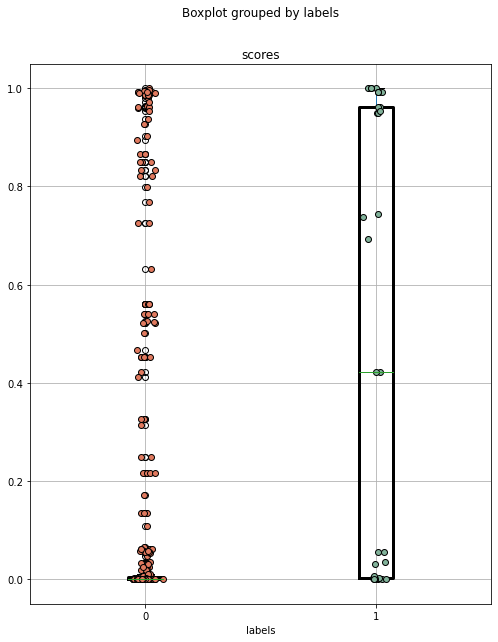

In [61]:
# boxplot of scores
labellist = []
scorelist = []
for accession in list(exp_labels.index):
    for phage in list(exp_labels.columns):
        labellist.append(exp_labels[phage][accession])
        scorelist.append(predicted_scores[phage][accession])
bxpltdf = pd.DataFrame({'scores':scorelist, 'labels': labellist})

fig, ax = plt.subplots(figsize=(8,10))
bxpltdf.boxplot(column='scores', by='labels', ax=ax, boxprops=dict(linewidth=3.0, color='black'))

for i, (k,d) in enumerate(bxpltdf.groupby('labels')):
    y = d['scores']
    x = np.random.normal(i+1, 0.02, len(y))
    ax.plot(x, y, mfc = ['#E07A5F','#81B29A'][i], mec='k', ms=6, marker="o", linestyle="None")
fig.savefig(results_path+'/boxplot_scores.png', dpi=400)

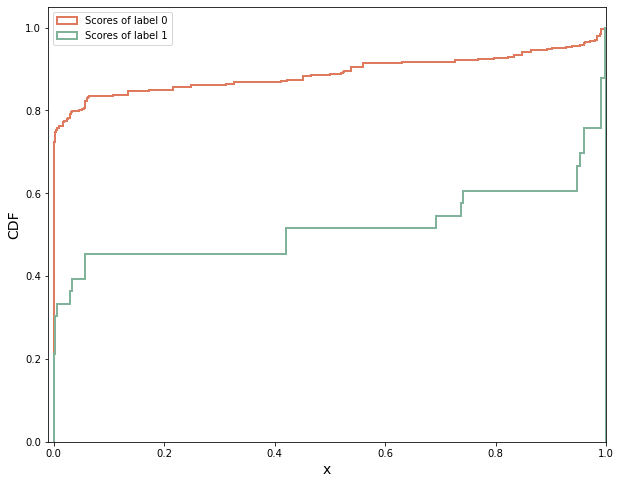

In [87]:
# cumulative distribution
scores0 = [score for i, score in enumerate(scorelist) if labellist[i] == 0]
scores1 = [score for i, score in enumerate(scorelist) if labellist[i] == 1]
fig,ax = plt.subplots(figsize=(10,8))
ax.hist(scores0, density=True, bins=500, cumulative=True, label='Scores of label 0',
         histtype='step', lw=2, color='#E07A5F')
ax.hist(scores1, density=True, bins=500, cumulative=True, label='Scores of label 1',
         histtype='step', lw=2, color='#81B29A')
ax.set_xlim(-0.01,1)
ax.set_xlabel('x', size=14)
ax.set_ylabel('CDF', size=14)
ax.legend(loc='upper left')
fig.savefig(results_path+'/CDF_scores.png', dpi=400)

In [9]:
# read the scores & experimental labels
loci_embeddings_path = test_path+'/esm2_embeddings_loci'+test_suffix+'.csv'
loci_embeddings = pd.read_csv(loci_embeddings_path)
predicted_scores = pd.read_csv(results_path+'/prediction_results'+test_suffix+'.csv')
predicted_scores = predicted_scores.set_index(pd.Index(list(loci_embeddings['accession'])))
#xlsx_file = results_path+'/experimental_labels'+test_suffix+'.xlsx'
xlsx_file = results_path+'/experimental_labels'+test_suffix+'.xlsx'
exp_labels = pd.read_excel(xlsx_file, index_col=0, header=0)

In [10]:
# plot with the training results as well
results_training = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'
with open(results_training+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
scores_hdc = logo_results['scores_hdc']
label_list = logo_results['labels']

rqueries_lan = []
for i in range(200):
    score_lan = scores_lan[i]
    y_test = label_list[i]
    if sum(y_test) > 0:
        ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
        rqueries_lan.append(ranked_lan)

In [11]:
# results, ROC AUC
scores_ens = []
for i in range(200):
    score_lan = scores_lan[i]
    score_hdc = scores_hdc[i]
    score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
    scores_ens.append(score_ens)
labels = np.concatenate(label_list).ravel()
scoreser = np.concatenate(scores_ens).ravel()
scoreslr = np.concatenate(scores_lan).ravel()

labels_test = []
scores_test = []
for bact in list(exp_labels.index):
    these_labels = list(exp_labels.loc[bact])
    these_scores = [predicted_scores.loc[bact][phage] for phage in list(exp_labels.columns)]
    labels_test.append(these_labels)
    scores_test.append(these_scores)
labels_test = np.concatenate(labels_test).ravel()
scores_test = np.concatenate(scores_test).ravel()

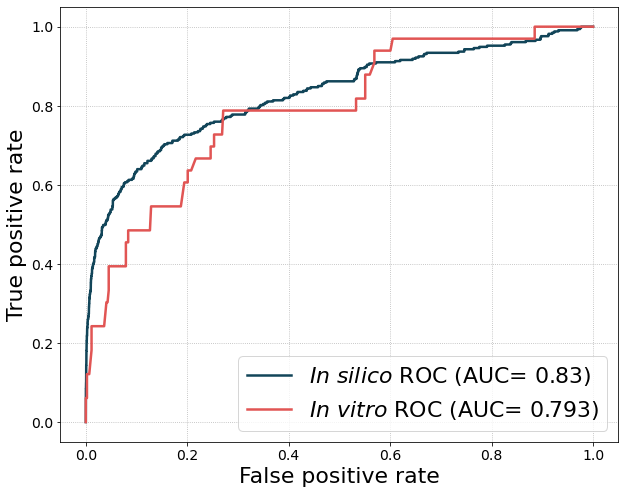

In [12]:
# results, ROC AUC
fig, ax = plt.subplots(figsize=(10,8))
fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='$\it{In}$ $\it{silico}$ ROC (AUC= '+str(rauclr)+')')
fpr, tpr, thrs = roc_curve(labels_test, scores_test)
raucer = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#E15554', linewidth=2.5, label='$\it{In}$ $\it{vitro}$ ROC (AUC= '+str(raucer)+')')
ax.set_xlabel('False positive rate', size=22)
ax.set_ylabel('True positive rate', size=22)
ax.legend(loc=4, prop={'size': 22})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/experimental_rocauc.png', dpi=400)
fig.savefig(results_path+'/experimental_rocauc_svg.svg', format='svg', dpi=400)

In [13]:
# compute ranked labels list
ranked_labels = []
random_labels = []
for bact in list(exp_labels.index):
    these_labels = list(exp_labels.loc[bact])
    if sum(these_labels) > 0: # only consider subset in which we found at least one confirmation
        these_scores = [predicted_scores.loc[bact][phage] for phage in list(exp_labels.columns)]
        these_ranked_labels = [x for _, x in sorted(zip(these_scores, these_labels), reverse=True)]
        ranked_labels.append(these_ranked_labels)
        random_labels.append(random.sample(these_ranked_labels, len(these_ranked_labels)))

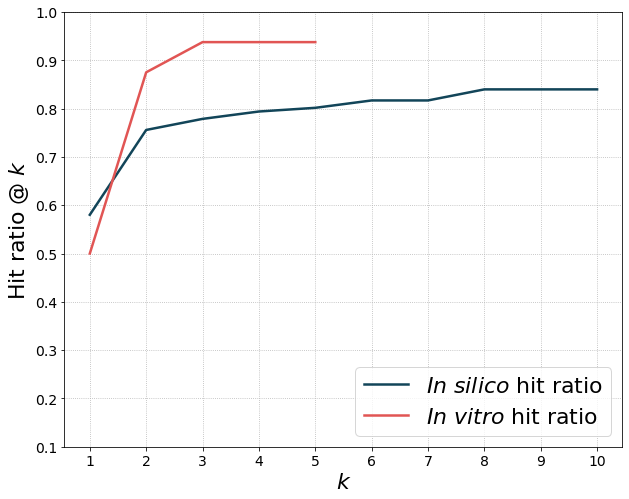

In [14]:
kens = np.linspace(1, 10, 10)
hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in kens]

ks = np.linspace(1, 5, 5)
hitratios = [phlu.hitratio(ranked_labels, int(k)) for k in ks]
random_hits = [phlu.hitratio(random_labels, int(k)) for k in ks]
#recalls = [phlu.recallatk(ranked_labels, int(k)) for k in ks]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(kens, hits_lan, c='#124559', linewidth=2.5, label='$\it{In}$ $\it{silico}$ hit ratio')
ax.plot(ks, hitratios, c='#E15554', linewidth=2.5, label='$\it{In}$ $\it{vitro}$ hit ratio')
#ax.plot(ks, recalls, c='#E15554', linewidth=2.5, ls=':', label='Experimental recall')
#ax.plot(kens, rec_ens, c='#124559', linewidth=2.5, ls=':', label='In silico recall')
#ax.plot(ks, random_hits, c='#81B29A', linewidth=2.5, label='Random guess')

ax.set_xlabel('$\it{k}$', size=22)
ax.set_ylabel('Hit ratio @ $\it{k}$', size=22)
ax.set_ylim(0.1, 1)
ax.legend(loc=4, prop={'size': 22})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_xticks(list(np.linspace(1, 10, 10)))

fig.savefig(results_path+'/experimental_hitratio.png', dpi=400)
fig.savefig(results_path+'/experimental_hitratio_svg.svg', format='svg', dpi=400)